# Set up

In [1]:
# numeric packages
import numpy as np
import pandas as pd

# filesystem and OS
import sys, os, time
import glob

# plotting
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

# compression
import gzip
import cPickle as pickle
import copy

# geo stuff
import geopandas as gpd
from shapely.geometry import Point, Polygon

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import warnings
warnings.filterwarnings('ignore')

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

In [2]:
# satellite imagery modules

import sys
sys.path.append("../../satellite-image-tools/satimage-processing/")
import satimg 

In [47]:
# Function to shorten class names for plotting

import re
import abbreviate
abbr = abbreviate.Abbreviate()

def split_str(s):
    s = re.sub('[^A-Za-z0-9% ]+', '', s)
    words = s.split(" ")
    words = [abbr.abbreviate(w, target_len=12).capitalize() for w in words]
    if len(words)==1:
        return s + "\n"
    if len(words)>4:
        words = words[:3] + [words[-1]]
    else:
        words = words[:4]
    return " ".join(words[:(len(words)/2)]) + "\n" + " ".join(words[(len(words)/2):])

In [3]:
# path to shapefiles
shapefiles_path = "/home/adalbert/data/urban-atlas/shapefiles/"

shapefiles = glob.glob("%s/*/*/*.shp"%shapefiles_path)
shapefiles = {" ".join(f.split("/")[-1].split("_")[1:]).replace(".shp",""):f for f in shapefiles}

len(shapefiles)

299

# Exploration of several cities

In [4]:
cities = ["barcelona", "berlin", "bucuresti"]

gdf = [gpd.GeoDataFrame.from_file(shapefiles[city]) for city in cities]
gdf = pd.concat(gdf)

gdf['SHAPE_AREA'] = gdf['SHAPE_AREA'] / 1.0e6 # convert to km^2
gdf['SHAPE_LEN'] = gdf['SHAPE_LEN'] / 1.0e3 # convert to km

classes = gdf['ITEM'].unique()

print gdf.shape

gdf.head()

(179726, 8)


CITIES   CODE                                          ITEM LUZ_OR_CIT  \
0  Barcelona  11300                           Isolated Structures     ES002L   
1  Barcelona  20000  Agricultural + Semi-natural areas + Wetlands     ES002L   
2  Barcelona  11300                           Isolated Structures     ES002L   
3  Barcelona  11300                           Isolated Structures     ES002L   
4  Barcelona  20000  Agricultural + Semi-natural areas + Wetlands     ES002L   

  PROD_DATE  SHAPE_AREA  SHAPE_LEN  \
0      2009    0.009417   0.381850   
1      2009    0.012014   0.674556   
2      2009    0.004409   0.276335   
3      2009    0.008023   0.350739   
4      2009    0.006188   0.358427   

                                            geometry  
0  POLYGON ((3663974.070238732 2075086.222298133,...  
1  POLYGON ((3663991.131878656 2074987.624112061,...  
2  POLYGON ((3664037.716254307 2074955.688018577,...  
3  POLYGON ((3664026.590693173 2074793.846370308,...  
4  POLYGON ((3663953.290812054 2074804.393111333,...

### Consolidate classes

In [10]:
gdf['class'] = gdf['ITEM']

consolidate_classes = {
    "Continuous Urban Fabric (S.L. > 80%)":"High Density Urban Fabric",
     "Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)":"High Density Urban Fabric",
     "Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)":"Medium Density Urban Fabric",
     "Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)":"Low Density Urban Fabric",
     "Discontinuous Very Low Density Urban Fabric (S.L. < 10%)":"Low Density Urban Fabric"
}
gdf['class'] = gdf['class'].apply(
    lambda x: consolidate_classes[x] if x in consolidate_classes else x)

# TODO!!!
# there is a bug here -- the high density urban fabric is not included (because of the 'continuous' below)!!
# another bug: medium density does not exist!
include_classes = ["Green urban areas", 
                   "Airports",
                   "Forests",
                   "Agricultural + Semi-natural areas + Wetlands",
                   # "Railways and associated land",
                   "High Density Urban Fabric", 
                    #"Mineral extraction and dump sites",
                   "Medium Density Urban Fabric", 
                   "Low Density Urban Fabric",
                   "Water bodies",
                   "Sports and leisure facilities",
                   "Industrial, commercial, public, military and private units"]
gdf = gdf[gdf['class'].isin(include_classes)]


### What percentage of polygons are there for each ground truth class?

In [6]:
pct_classes = gdf.groupby('CITIES').apply(\
                        lambda x: (x['class'].value_counts() /  float(len(x))))

pct_classes = pct_classes.reset_index().rename(columns={"level_1":"land class", "class":"pct"})
pct_classes.head()

CITIES                                         land class       pct
0  Barcelona                          High Density Urban Fabric  0.424761
1  Barcelona                           Low Density Urban Fabric  0.120440
2  Barcelona  Industrial, commercial, public, military and p...  0.120254
3  Barcelona       Agricultural + Semi-natural areas + Wetlands  0.119098
4  Barcelona                        Medium Density Urban Fabric  0.092735

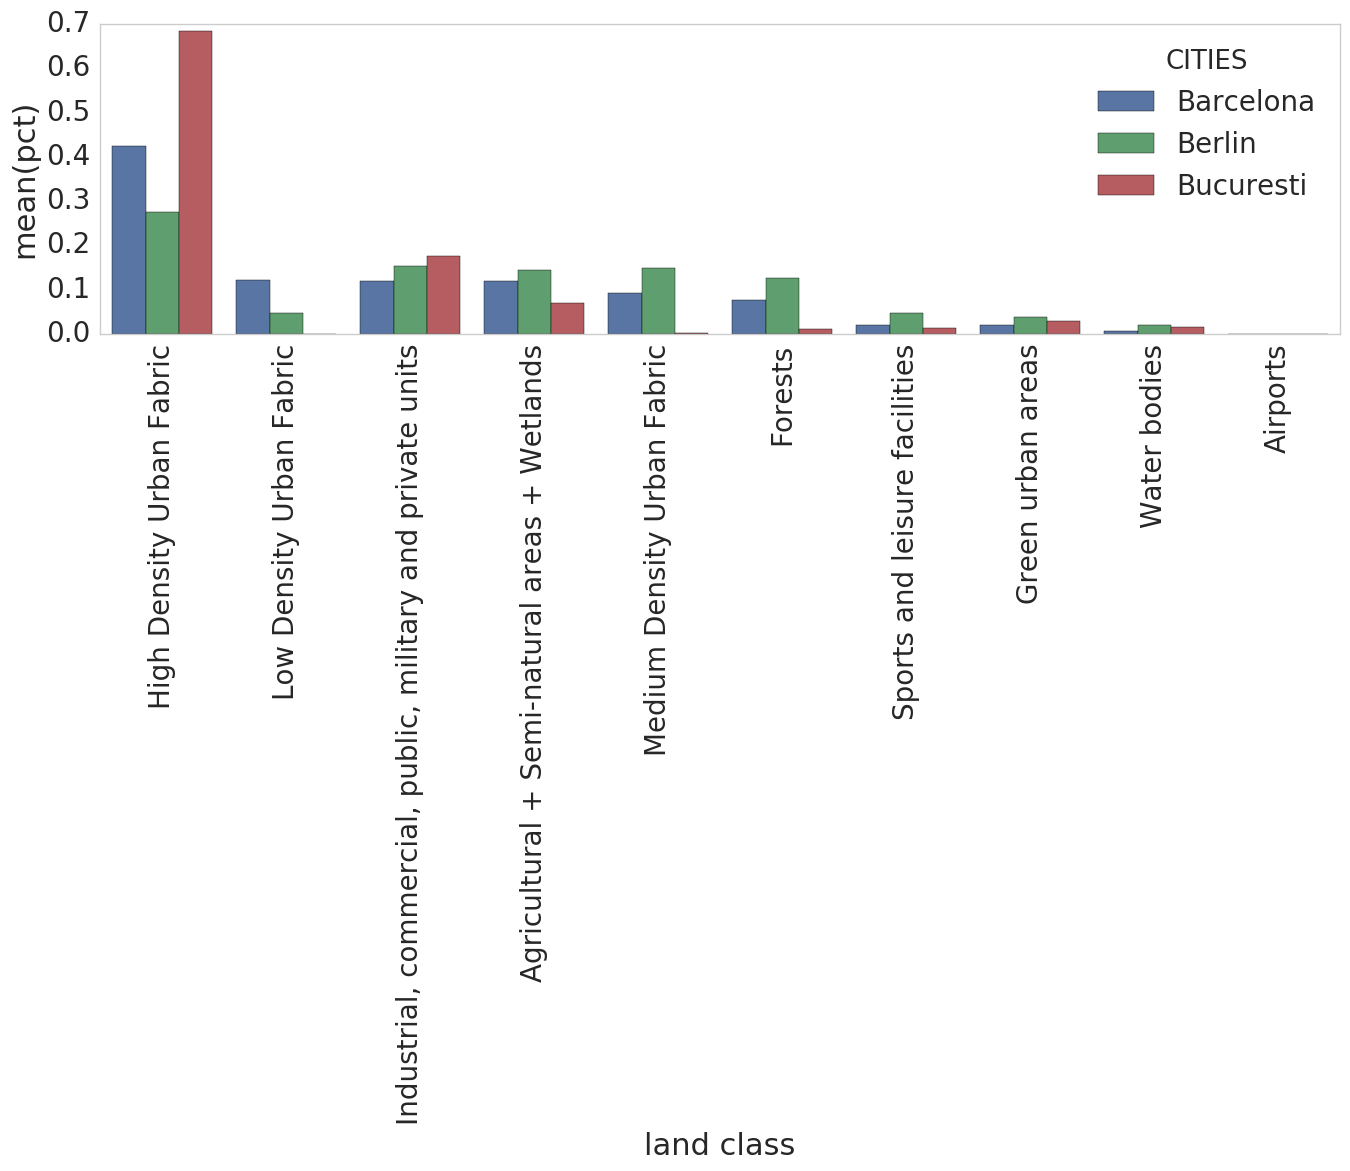

In [9]:
fig, ax = plt.subplots(figsize=(16,4))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})
pl = sns.barplot(data=pct_classes, \
                 x="land class", y="pct", hue="CITIES", estimator=np.mean,\
                 ax=ax)
for item in pl.get_xticklabels():
    item.set_rotation(90)

### Show some example polygons for each class

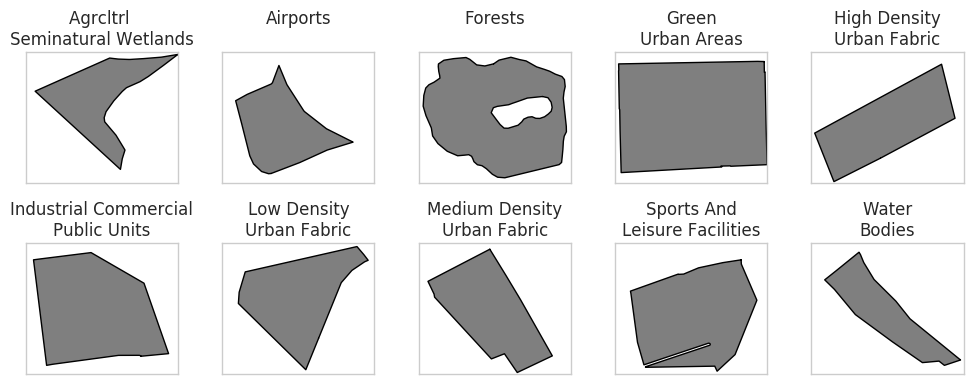

In [51]:

sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
sample_polygons = gdf.groupby("class").apply(lambda x: x.sample(1))

fig, ax = plt.subplots(2,5, figsize=(10,4), squeeze=False)
for n,(idx,p) in enumerate(sample_polygons.iterrows()):
    i = n/5; j = n % 5
    gpd.GeoDataFrame(p).T.plot(ax=ax[i,j])
    ax[i,j].set_title(split_str(p['class']))
    ax[i,j].set_yticks([])    
    ax[i,j].set_xticks([])
plt.tight_layout()

#### Look at polygon areas and perimeters. 

We ultimately want to extract images 224 x 224 in size, with a spatial resolution of ~2-3m, as to correspond to tiles of 500m x 500m. As such, we would like to ensure to sample polygons that have at least a $0.25km^2$ square area.

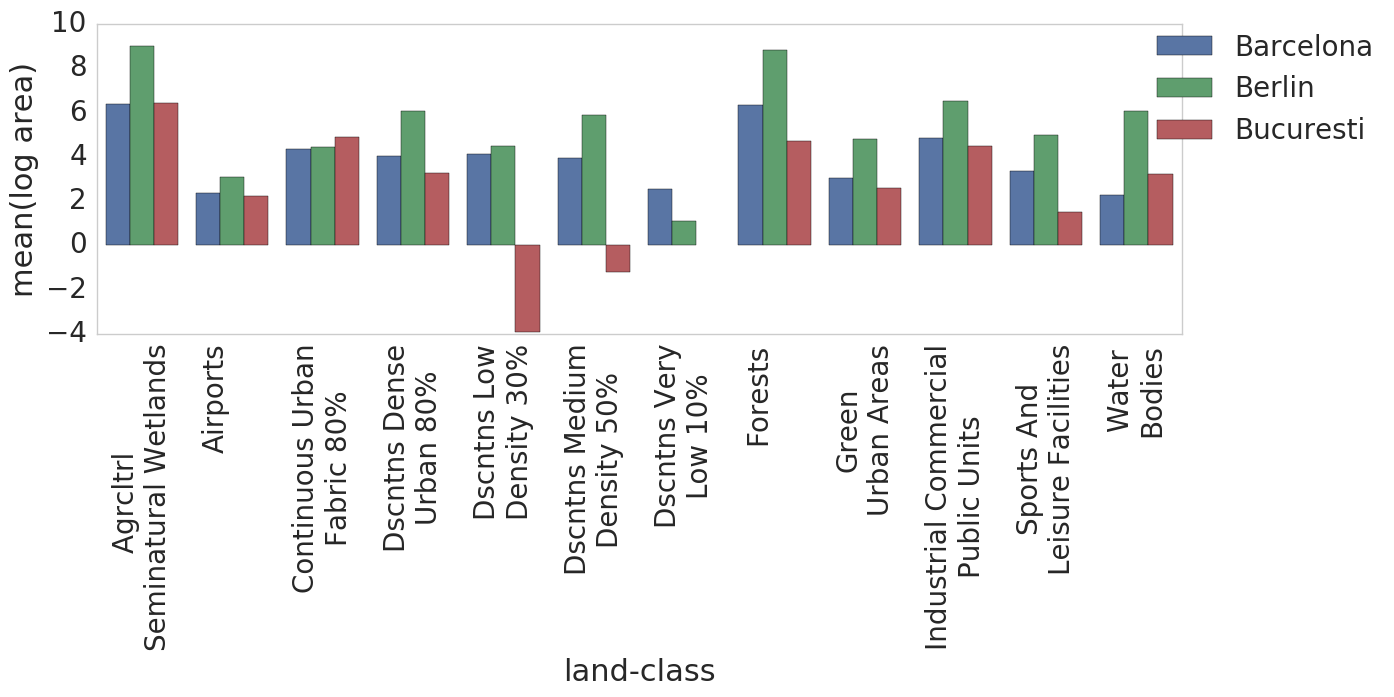

In [60]:
area_per_class = gdf.groupby(["CITIES", "land-class"]).apply(lambda x: x['SHAPE_AREA'].sum())
area_per_class = pd.DataFrame(area_per_class).reset_index()
area_per_class.rename(columns={0:"area"}, inplace=True)
area_per_class['log area'] = area_per_class['area'].apply(np.log)

fig, ax = plt.subplots(figsize=(14,4))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})
pl = sns.barplot(data=area_per_class, \
                 x="land-class", y="log area", hue="CITIES", estimator=np.mean,\
                 ax=ax)
for item in pl.get_xticklabels():
    item.set_rotation(90)

ax.legend(bbox_to_anchor=(1.2, 1.05))

In [ ]:
gdf.groupby(["CITIES"]).apply(lambda x: len(x))

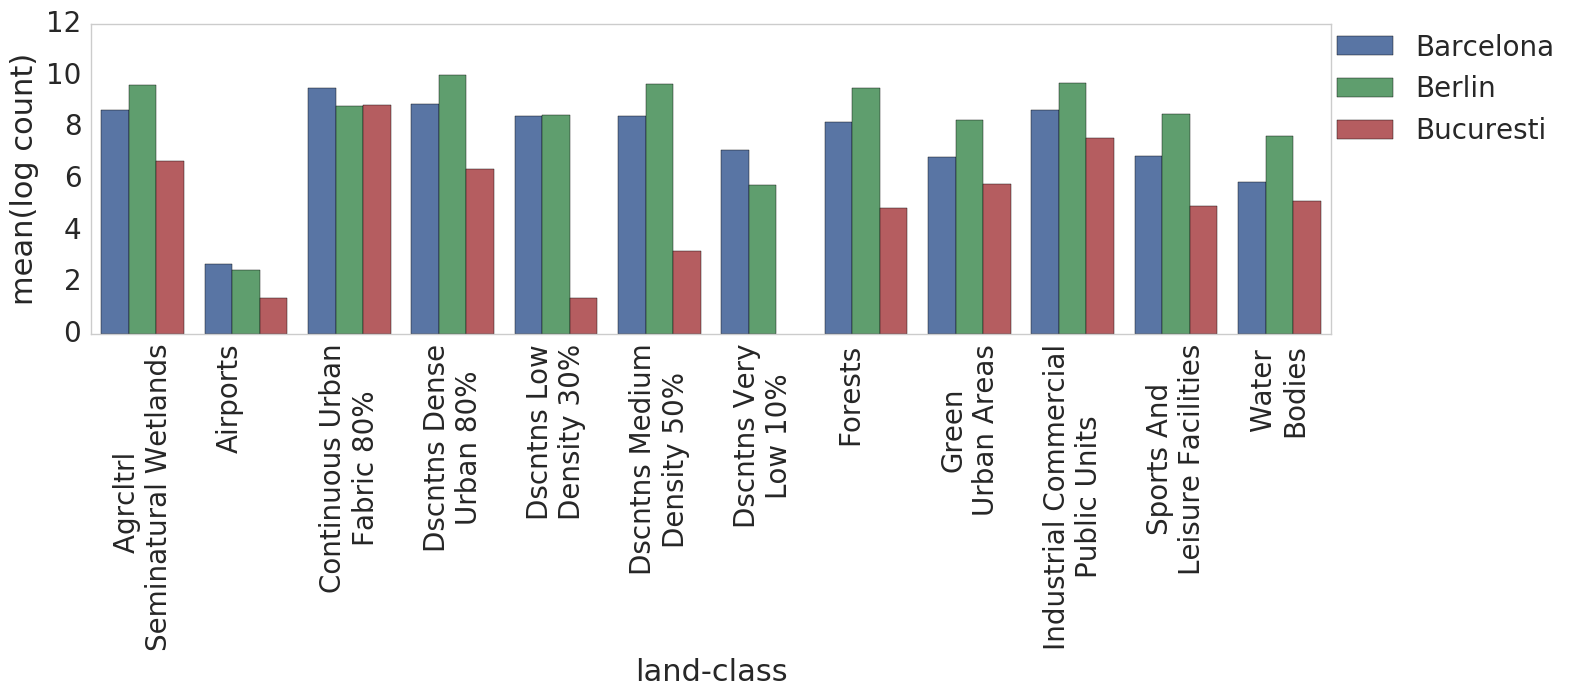

In [63]:
polygons_per_class = gdf.groupby(["CITIES", "land-class"])\
                        .apply(lambda x: len(x)) / \


polygons_per_class = pd.DataFrame(polygons_per_class).reset_index()
polygons_per_class.rename(columns={0:"count"}, inplace=True)
polygons_per_class['log count'] = polygons_per_class['count'].apply(np.log)

fig, ax = plt.subplots(figsize=(16,4))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})
pl = sns.barplot(data=polygons_per_class, \
                 x="land-class", y="log count", hue="CITIES", estimator=np.mean,\
                 ax=ax)
for item in pl.get_xticklabels():
    item.set_rotation(90)
ax.legend(bbox_to_anchor=(1.2, 1.05))

### Illustrate sampling strategy.

Most classes are "fat". However roads are skinny. 
* For "fat" polygons, we can sample the convex hull and we'll probably be fine.
* For "skinny" polygons, we can sample around some of the points on the boundary of the polygon.


In [ ]:
(gdf['SHAPE_AREA']>0.06).sum() / float(len(gdf))

In [ ]:
gdf[gdf['SHAPE_AREA']>0.06]['ITEM'].value_counts()

In [ ]:
# satellite imagery modules

import sys
sys.path.append("../../../satellite-image-tools/satimage-processing/")
import satimg 
 
import sys
sys.path.append("../../../satellite-image-tools/google-maps-api/")
import GoogleMaps as gmaps 

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

df1 = sample_polygons[sample_polygons['ITEM'].isin(['Other roads and associated land'])]
p1  = df1['geometry'].values[0]
loc1= np.array(satimg.generate_locations_within_polygon(p1, nSamples = 10, strict=True))

ch1 = df1['geometry'].convex_hull
df1.plot(ax=ax[1], color="green")
ch1.plot(ax=ax[1])
ax[1].scatter(loc1[:,0], loc1[:,1], s=150, marker=".", c="red")
ax[1].set_title("Other roads and associated land\n", fontsize=16)

df2 = sample_polygons[sample_polygons['ITEM'].isin(['Green urban areas'])]
p2  = df2['geometry'].values[0]
loc2= np.array(satimg.generate_locations_within_polygon(p2, nSamples = 10, strict=True))

ch2 = df2['geometry'].convex_hull
ax[0].scatter(loc2[:,0], loc2[:,1],s=150, marker=".", c="red")
df2.plot(ax=ax[0], color="green")
ch2.plot(ax=ax[0])
ax[0].set_title('Green urban areas\n', fontsize=16)

for a in ax:
    a.set_yticks([])
    a.set_xticks([])
    
plt.tight_layout()

Sampling strategy: sample evenly from each of the deciles of the distribution

In [ ]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
g = sns.FacetGrid(gdf[gdf['ITEM'].isin(["Other roads and associated land", "Green urban areas"])], \
                  col="land-class",  col_wrap=2, size=4, sharex=True, sharey=False)
g.map(sns.distplot, "LOG_SHAPE_AREA", color=".3", bins=10, hist=True)\
    .add_legend()

In [ ]:
gdf.head(10).intersects(gdf).sum()

# Statistics on all ~300 cities in Urban Atlas

Use computation results from the separate notebook "Urban Atlas - generate sampling locations"

### Statistics on classified area and spatial extent of the city

* What is the total area covered by the land use classification? 
* How does it break down into the different classes?
* What is the spatial extent scale of the city?

In [64]:
datapath = "/home/adalbert/data/urban-atlas/extracted-data/"

stats_files = glob.glob("%s/*/basic_stats.csv"%datapath)

basic_stats_df = pd.concat([pd.read_csv(f) for f in stats_files]).drop("Unnamed: 0", 1)
basic_stats_df.index = [f.split("/")[-2] for f in stats_files]
basic_stats_df.head()

spatial extent  pct land classified
laquila         53.177852             0.562870
tilburg         27.605788             0.555366
coventry        39.533000             0.567860
cremona         32.492391             0.635609
groningen       44.841774             0.468918

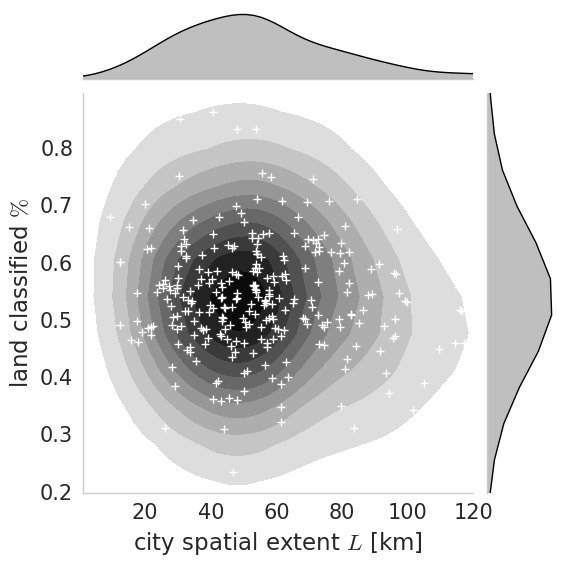

In [65]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(8,4))
g = sns.jointplot(x="spatial extent", y="pct land classified", data=basic_stats_df, \
                  kind="kde", color="k", ylim=(0.2,0.9), xlim=(1,120), stat_func=None)
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("city spatial extent $L$ [km]", "land classified $\%$");

In [68]:
class_stats_files = glob.glob("%s/*/stats_class_window*.csv"%datapath)

class_stats_df = []
for f in class_stats_files:
    df = pd.read_csv(f)
    df.insert(0, "city", f.split("/")[-2])
    class_stats_df.append(df)
class_stats_df = pd.concat(class_stats_df).drop("Unnamed: 0", 1)
class_stats_df['land class'] = class_stats_df['ITEM'].apply(lambda x: split_str(x) if not pd.isnull(x) else x)
class_stats_df.dropna(inplace=True)
class_stats_df['window km'] = class_stats_df['window km'].astype(int)
class_stats_df.head()

ITEM     city  pct area  \
0       Agricultural + Semi-natural areas + Wetlands  laquila  0.401806   
1                                           Airports  laquila  0.000081   
2                                 Construction sites  laquila  0.000253   
3               Continuous Urban Fabric (S.L. > 80%)  laquila  0.000612   
4  Discontinuous Dense Urban Fabric (S.L. : 50% -...  laquila  0.005316   

   pct classified area  pct polygons  window km  \
0             0.647187      0.966997         50   
1             0.000131      1.000000         50   
2             0.000407      0.983871         50   
3             0.000986      0.985782         50   
4             0.008562      0.987585         50   

                        land class  
0  Agrcltrl \nSeminatural Wetlands  
1                       Airports\n  
2                  Cnstrctn\nSites  
3     Continuous Urban\nFabric 80%  
4         Dscntns Dense\nUrban 80%

### Statistics on classified area and spatial extent of the city

* What is the total area covered by the land use classification? 
* How does it break down into the different classes?
* What is the spatial extent scale of the city?

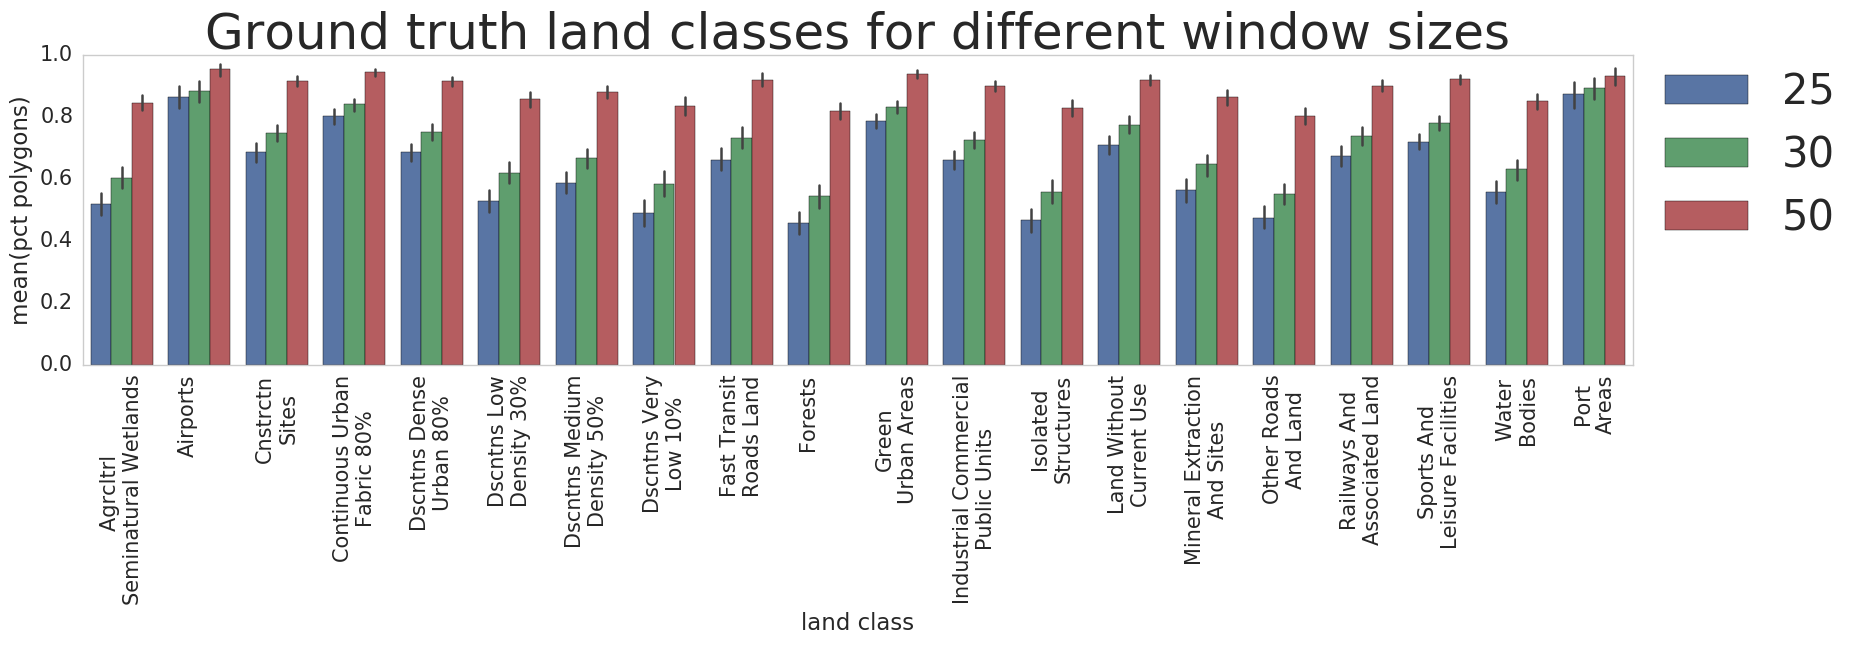

In [69]:
fig, ax = plt.subplots(figsize=(20,4))
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 1})
pl = sns.barplot(data=class_stats_df, x="land class", y="pct polygons", hue="window km", estimator=np.mean,\
                 ax=ax)
for item in pl.get_xticklabels():
    item.set_rotation(90)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title("Ground truth land classes for different window sizes")

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 1})
pl = sns.barplot(data=class_stats_df, x="land class", y="pct classified area", hue="window km", estimator=np.mean,\
                 ax=ax)
for item in pl.get_xticklabels():
    item.set_rotation(90)

#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax.set_title("Ground truth classified area for different window sizes")

In [ ]:
cur_df = class_stats_df[class_stats_df['city'].isin(["barcelona", "berlin", "bucuresti"]) & \
                        (class_stats_df['window km']==25)]

fig, ax = plt.subplots(figsize=(20,4))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})
pl = sns.barplot(data=cur_df, x="land class", y="pct polygons", hue="city", estimator=np.mean,\
                 ax=ax)
for item in pl.get_xticklabels():
    item.set_rotation(90)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title("Urban area land use classes comparison for three cities (W=25km)")
#plt.legend(loc="best")

# Example images

In [81]:
def plot_examples(images, labels, classes=None, \
                  nExamples=10, thumbSize = (50,50), title="example"):
    # build example canvass 
    from skimage.transform import resize
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.zeros((thumbSize[0]*nClusters, nExamples*thumbSize[1], 3))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = images[idx[j],:,:,:3]
            img = resize(img, thumbSize)
            canvas[i*thumbSize[0]:(i+1)*thumbSize[0], j*thumbSize[1]:(j+1)*thumbSize[1]] = img
    
    # plot examples of each class
    fig,ax = plt.subplots(1, figsize=(12,10))
    plt.tight_layout()
    print canvas.shape
    ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
    ax.set_title(title, fontsize=18)
    ax.set_ylabel("-- examples --", fontsize=16)
    ax.set_xlabel("-- land classes --", fontsize=16)
    # Turn off tick labels
    if classes is None: classes = clustLabels
    ax.set_xticks([thumbSize[0]*(0.5 + x) for x in range(nClusters)])
    ax.set_xticklabels(classes, fontsize=16, rotation=90)
    ax.set_yticklabels([])
    #plt.axis("off")
    plt.show()

In [74]:
img_dir = "/home/adalbert/data/urban-atlas/extracted-data/berlin/img/"

import glob

files = np.array(glob.glob(img_dir + "/*/*.jpg"))

files_df =  pd.DataFrame(files).rename(columns={0:"filename"})
files_df['class'] = files_df['filename'].apply(lambda x: x.split("/")[-2])
files_df['city'] = files_df['filename'].apply(lambda x: x.split("/")[-3])

files_df.head()

filename  \
0  /home/adalbert/data/urban-atlas/extracted-data...   
1  /home/adalbert/data/urban-atlas/extracted-data...   
2  /home/adalbert/data/urban-atlas/extracted-data...   
3  /home/adalbert/data/urban-atlas/extracted-data...   
4  /home/adalbert/data/urban-atlas/extracted-data...   

                                  class city  
0  Continuous Urban Fabric (S.L. > 80%)  img  
1  Continuous Urban Fabric (S.L. > 80%)  img  
2  Continuous Urban Fabric (S.L. > 80%)  img  
3  Continuous Urban Fabric (S.L. > 80%)  img  
4  Continuous Urban Fabric (S.L. > 80%)  img

In [77]:
files_df['class'] = files_df['class'].apply(
    lambda x: consolidate_classes[x] if x in consolidate_classes else x)
files_df = files_df[files_df['class'].isin(include_classes)]

In [78]:
n_samples = 10

sel_df = files_df.groupby("class").apply(lambda x: x.sample(n_samples))

from skimage.io import imread
images = np.array(sel_df['filename'].apply(imread).values.tolist())
labels = sel_df['class'].apply(split_str)

(500, 500, 3)


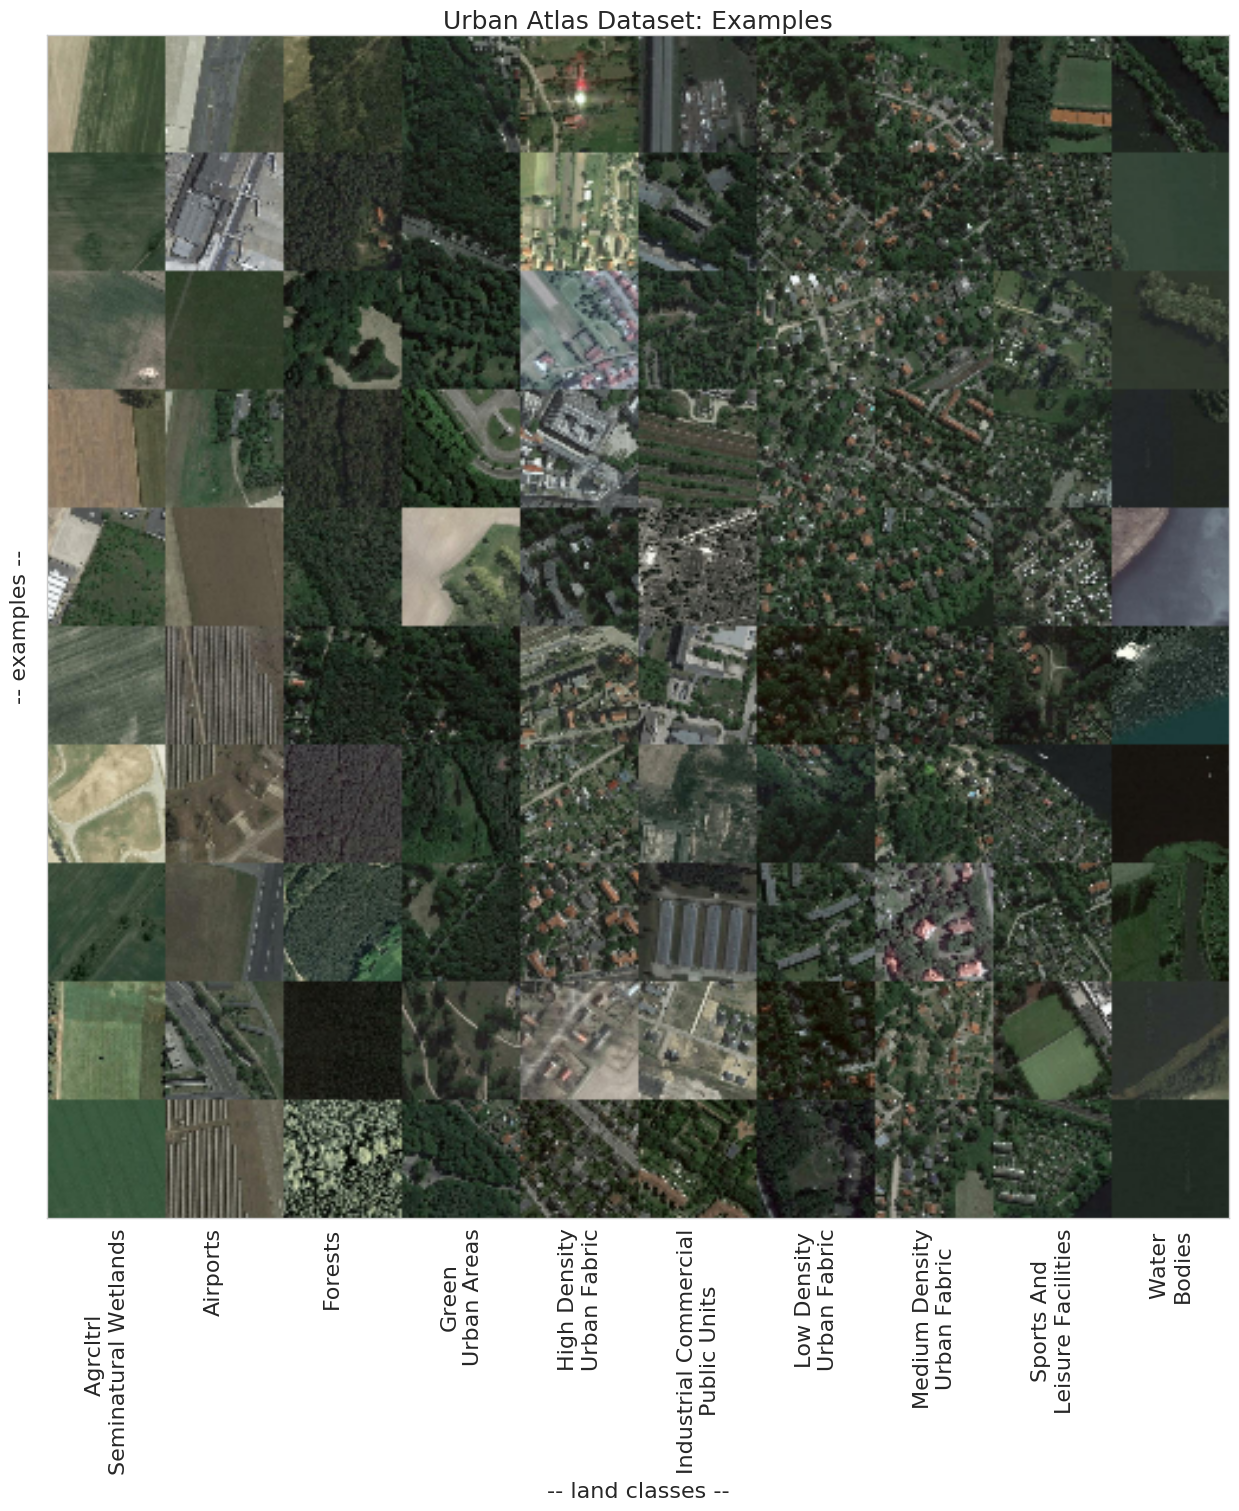

In [79]:
plot_examples(images, labels, nExamples=10, thumbSize = (50,50), title="Urban Atlas Dataset: Examples")

(500, 250, 3)


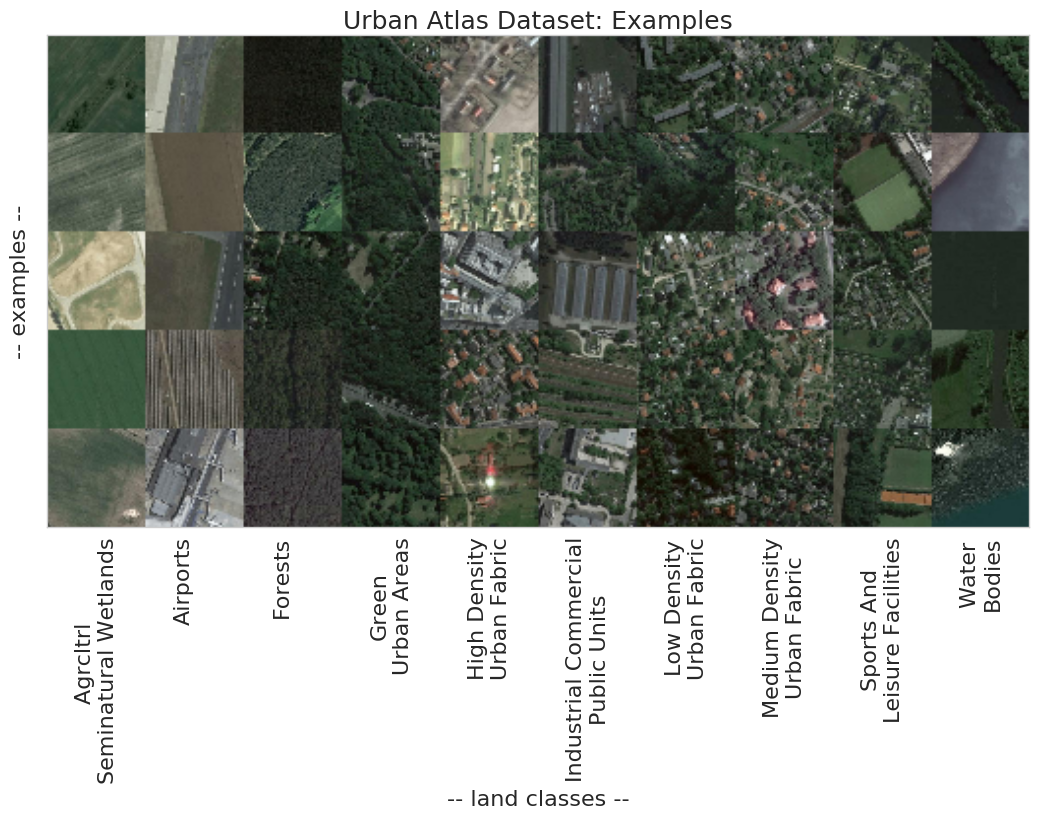

In [82]:
plot_examples(images, labels, nExamples=5, thumbSize = (50,50), title="Urban Atlas Dataset: Examples")